<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/labs/ARIMA_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load DataFrames called `logins`, `paper` and `pollution` from chapter 7 of Makridakis.

In [2]:
! pip install --upgrade statsmodels

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

!curl https://vcu-scma-440.s3.amazonaws.com/data/pollution.csv > pollution.csv
!curl https://vcu-scma-440.s3.amazonaws.com/data/logins.csv > logins.csv
!curl https://vcu-scma-440.s3.amazonaws.com/data/paper.csv > paper.csv

paper = pd.read_csv('paper.csv', parse_dates=['date']).set_index('date')
logins = pd.read_csv('logins.csv')
pollution = pd.read_csv('pollution.csv', parse_dates=['date']).set_index('date')


Requirement already up-to-date: statsmodels in /opt/miniconda3/lib/python3.7/site-packages (0.12.2)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2527  100  2527    0     0  20216      0 --:--:-- --:--:-- --:--:-- 20216
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   380  100   380    0     0   3762      0 --:--:-- --:--:-- --:--:--  3725
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2259  100  2259    0     0  25670      0 --:--:-- --:--:-- --:--:-- 25670


# ARIMA for Seasonal Data

Let's begin by taking a look at the `paper` `DataFrame`

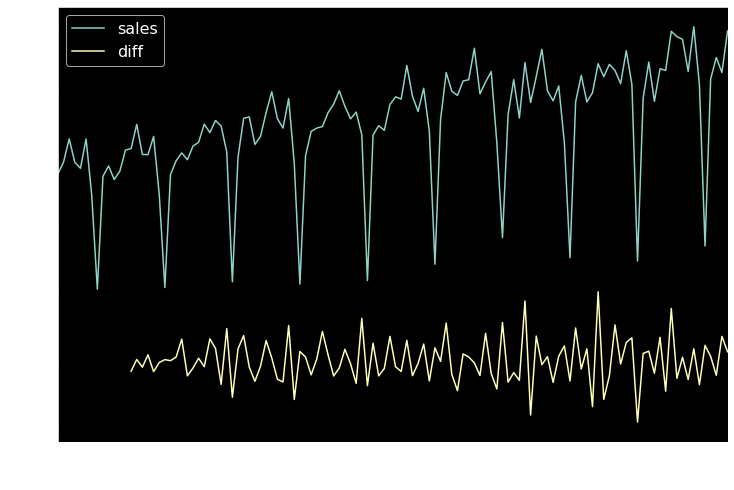

In [18]:
display(paper.plot())

This data is clearly seasonal, and will likely need seasonal differencing. Let's first try differencing both at lag 1 and lag 12 and plotting the results. To difference the data at two different lags in one line, you can type (e.g. for a single and quarterly differencing):

```python
data['diff'] = data['original'].diff(1).diff(4)
```

Below, create a new column in the `paper` `DataFrame` called `diff` that contains the one-month and 12 month differenced data. Then plot the new, differenced column.


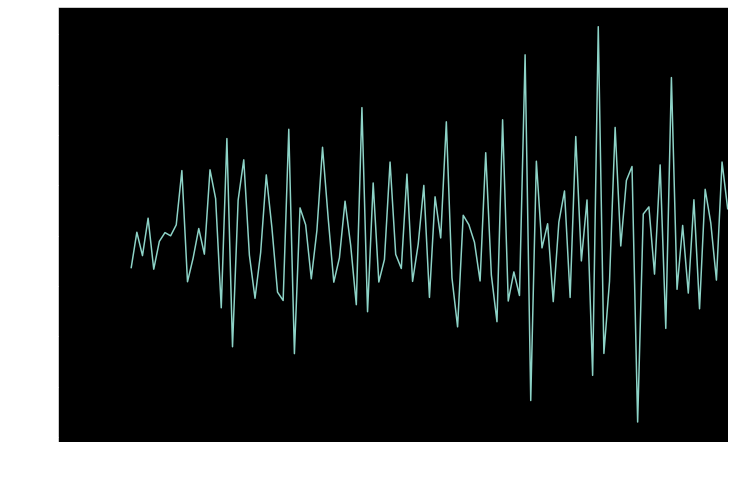

In [19]:
# YOUR CODE HERE
paper['diff'] = paper['sales'].diff(1).diff(12)
paper['diff'].plot()

This data clearly looks much more stationary, and implies that we'll need to fit a seasonal ARIMA model with: $$(p,1,q)(P,1,Q)_{12}$$.

Do determine the values of `p,q,P,Q`, let's take a look at the ACF and PACF plots for the differenced data. In the cell below, plot the ACF and PACF plots for the differenced data. 

In your call to compute the ACF/PACF, make sure to add the `zero=False` to ensure the first value isn't plotted. Also, instead of passing in `paper['diff']`, pass in `paper['diff'].dropna()` to ensure that missing values are dropped (they will prevent the plot from printing properly). 

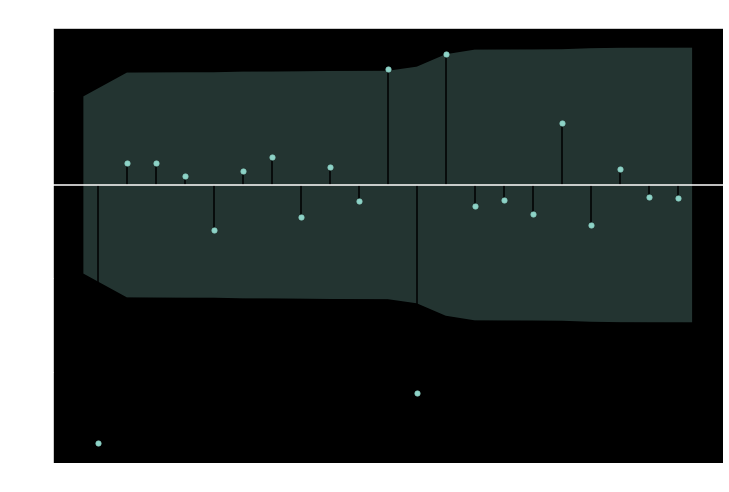

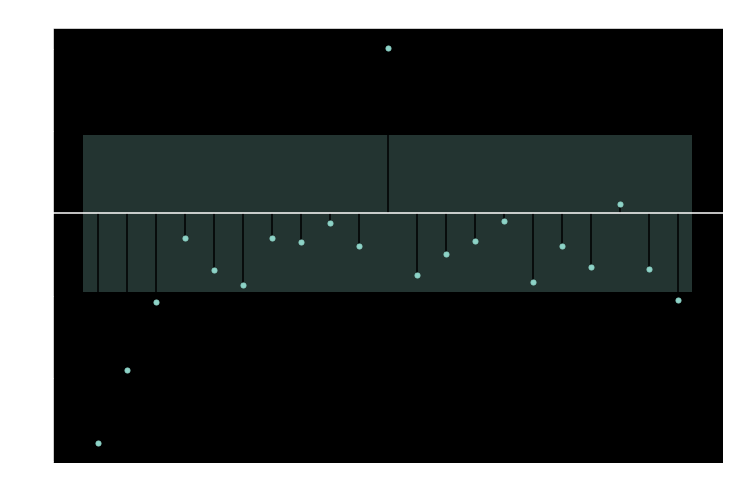

In [20]:
# YOUR CODE HERE

my_acf = plot_acf(paper['diff'].dropna(), zero=False)
my_pacf = plot_pacf(paper['diff'].dropna(), zero=False)

From the above, the exponential decay of the first several values in the PACF suggest a non-seasonal MA(1), while the spike in the ACF and PACF at lag 12 suggest a seasonal MA(1) for seasonality of 12. This would suggest a model of the form:

$$(0,1,1)(0,1,1_{12}$$.

We can specify this model using the `ARIMA` function, by passing in (with appropriate values for all of the order parameters):

```python
model = ARIMA(data['original'], order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
print(results.summary())
```

In the cell below, fit and print the summary for the seasonal model identified above.

In [21]:
## YOUR CODE HERE

model = ARIMA(paper['sales'], order=(0,1,1), seasonal_order=(0,1,1,12))
results = model.fit()
print(results.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            sales   No. Observations:                  120
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -556.943
Date:                          Sun, 11 Apr 2021   AIC                           1119.886
Time:                                  18:39:03   BIC                           1127.904
Sample:                              01-01-1963   HQIC                          1123.136
                                   - 12-01-1972                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8401      0.057    -14.732      0.000      -0.952      -0.728
ma.S.L12      -0.6351      0.097     -6.536      0.

/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## Questions:
1. Are the model parameters significant?
2. Judging by the p-value for the Ljung-Box statistic, do the residuals display any autocorrelation?

Let's finish up by computing the ACF and PACF for the residuals. In the cell below, plot these and comment on any remaining autocorrelation or partial autocorrelation remaining. 

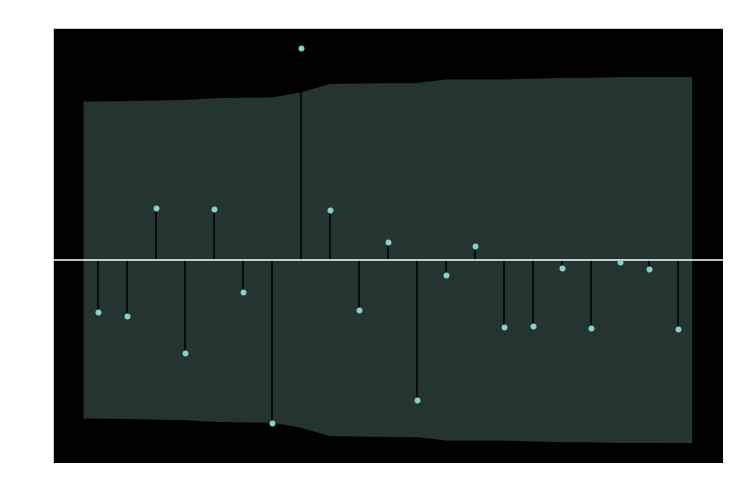

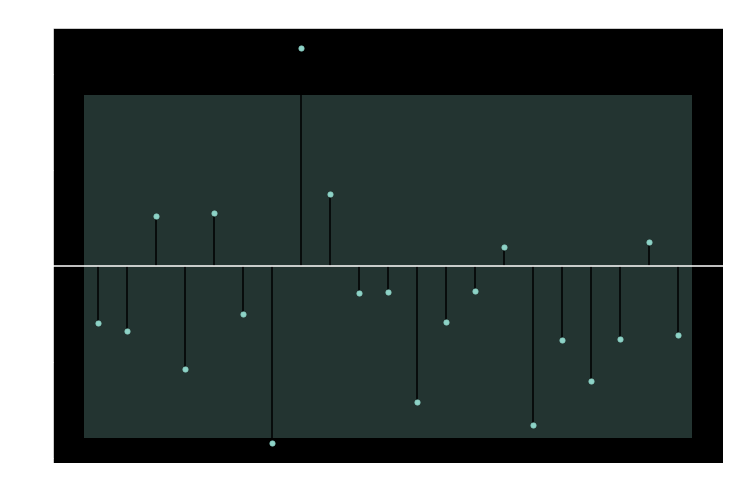

In [23]:
# YOUR CODE HERE

my_acf = plot_acf(results.resid, zero=False)
my_pacf = plot_pacf(results.resid, zero=False)